<a href="https://colab.research.google.com/github/hemantnyadav/time-series-forecasting/blob/main/Single_Step_Univariate_Time_Series_energy_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Research Paper 1, Experiment 1
### Univariate Time Series forecating using variation of LSTM

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf

from LSTM_CIFG import LSTM_CIFG
from LSTM_NFG import LSTM_NFG
from LSTM_NIA import LSTM_NIA
from LSTM_NIG import LSTM_NIG
from LSTM_NOA import LSTM_NOA
from LSTM_NOG import LSTM_NOG
from tensorflow.keras.layers import *
from LSTM_PeepHole import PeepholeLSTMCell

from tensorflow.keras.models import Sequential

#from tf.tfa.rnn import PeepholeLSTMCell as LSTM_Peephole

!pip install sktime
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 10.3 MB/s eta 0:00:00


In [3]:
#df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')
df = pd.read_csv('energydata_complete.csv')

<Axes: xlabel='date'>

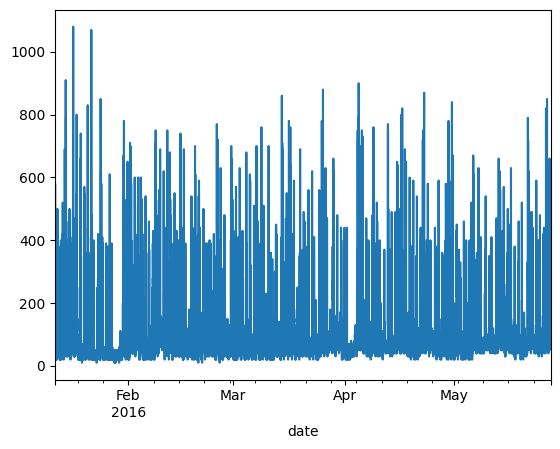

In [4]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
#df.set_index('date')
df.set_index('date',inplace=True)
df['Appliances'].plot()

In [5]:
df.shape, df.columns,df.describe()

((19735, 28),
 Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
        'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
        'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
        'Tdewpoint', 'rv1', 'rv2'],
       dtype='object'),
          Appliances        lights            T1          RH_1            T2  \
 count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
 mean      97.694958      3.801875     21.686571     40.259739     20.341219   
 std      102.524891      7.935988      1.606066      3.979299      2.192974   
 min       10.000000      0.000000     16.790000     27.023333     16.100000   
 25%       50.000000      0.000000     20.760000     37.333333     18.790000   
 50%       60.000000      0.000000     21.600000     39.656667     20.000000   
 75%      100.000000      0.000000     22.600000     43.066667     21.500000   
 max     1080.000000     70.000000     26.260000   

In [6]:
columns = ['Appliances']

In [7]:
train_df = df[columns].iloc[0:13814,:]
val_df = df[columns].iloc[13814:16774,:]
test_df = df[columns].iloc[16774:,:]

In [8]:
num_features  = len(columns)
input_width = 24
label_width = 1
OUT_STEPS = 1
shift = 1
MAX_EPOCHS = 20


Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['Appliances']

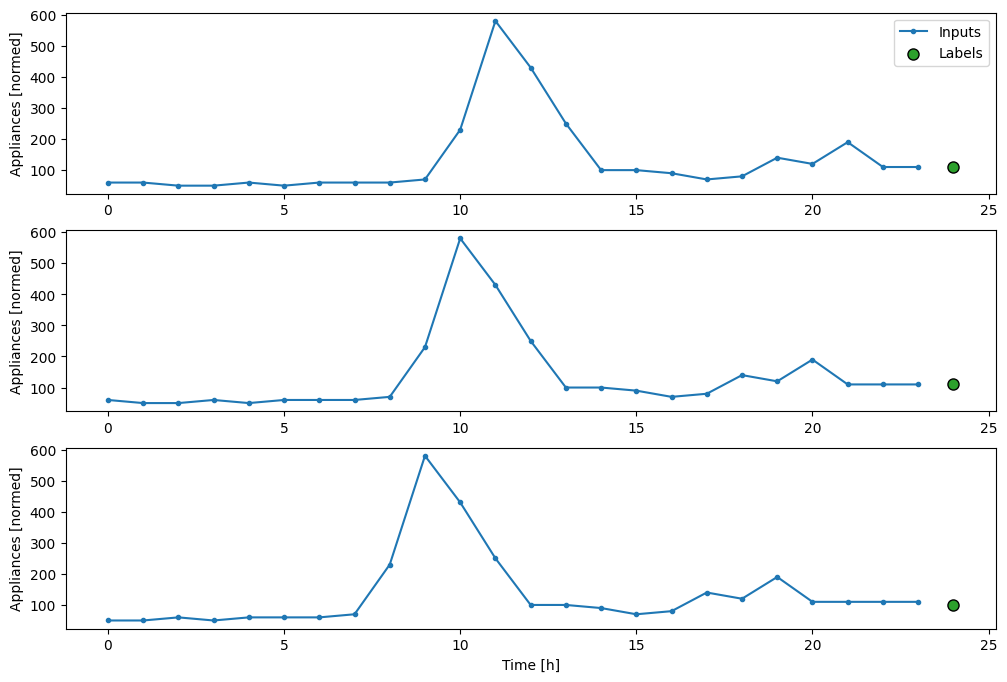

In [9]:
from WindowGenerator import WindowGenerator

single_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=1,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_columns=['Appliances'])

single_window.plot()
single_window

## All Model

In [10]:
def create_compile_fit_model(layer_name,  window, patience=2):
  if layer_name==LSTM:
    layer_name = tf.keras.layers.LSTM(64, return_sequences=False)  
  elif layer_name==GRU:
    layer_name =  tf.keras.layers.GRU(64, return_sequences=False)
  else:
    layer_name = tf.keras.layers.RNN(layer_name(64), return_sequences=False)
  
  model = tf.keras.Sequential([
    layer_name,
    #tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping], verbose=0)
  return history,model



def evaluate_model(predictions, actuals,y_train):
  '''
  predictions: 1d array
  actuals: 1d array
  y_train: training values for evaluating naive forecast
  '''
  if(len(predictions)!=len(actuals)):
    return "Error: lenght of predition and actuals not equal"
  rmse = np.sqrt(np.average((predictions-actuals)**2))
  mse = np.average((predictions-actuals)**2)
  mae  = np.average(abs(predictions-actuals))
  #mape  = np.average(abs((predictions-actuals)/actuals))
  mase = mean_absolute_scaled_error(actuals, predictions, y_train=y_train)
  evaluation = {}

  evaluation['rmse'] = rmse
  evaluation['mae']= mae
  evaluation['mse']= mse
  evaluation['mase'] = mase
  return evaluation

def evaluate_all_model(models, window, y_train):
  
  result_df =pd.DataFrame(columns = ['rmse','mae','mse','mase'])
  ind = []

  for model_name,model in models.items():
    predictions = model.predict(window.train).ravel()
    actuals     = train_df['Appliances'][24:].values
    evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
    result_df   = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)
    ind.append(model_name)

    # Result for Val Data
    predictions = model.predict(window.val).ravel()
    actuals     = val_df['Appliances'][24:].values
    evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
    result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)
    ind.append(model_name)

    # Result for Test Data
    predictions = model.predict(window.test).ravel()
    actuals     = test_df['Appliances'][24:].values
    evalution   = evaluate_model(predictions,actuals,train_df['Appliances'].values)
    result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)
    ind.append(model_name)

    
  
  return result_df,ind


In [11]:

models = [LSTM, GRU, LSTM_CIFG, LSTM_NFG, LSTM_NIA, LSTM_NIG, LSTM_NOA, LSTM_NOG,PeepholeLSTMCell ]
models_name = np.array(['LSTM', 'GRU', 'CIFG', 'NFG', 'NIA', 'NIG', 'NOA', 'NOG','PeepholeLSTMCell' ])
dataset_name = ['Train', 'Val', 'Test']

In [12]:
%%time

np.random.seed(16)
tf.random.set_seed(16)
models_all = {}
history_all = {}
for model, model_name in zip(models, models_name):
  history,model = create_compile_fit_model(model,single_window)
  models_all[model_name] = model
  history_all[model_name] = history

built
built
built








built
built
built


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


CPU times: user 49min 40s, sys: 1min 37s, total: 51min 18s
Wall time: 43min 31s


In [13]:
%%time
result_df,ind = evaluate_all_model(models_all, single_window, train_df['Appliances'].values)
result_df.index = ind
result_df

92/92 [==============================] - 1s 8ms/step


92/92 [==============================] - 1s 12ms/step
CPU times: user 1min 13s, sys: 5.31 s, total: 1min 18s
Wall time: 1min 11s


,rmse,mae,mse,mase
LSTM,77.672445,33.504653,6033.008696,1.084196
LSTM,65.667980,27.026696,4312.283592,0.874572
LSTM,67.225818,27.616787,4519.310611,0.893667
GRU,75.794098,33.190996,5744.745277,1.074046
GRU,64.197562,26.846957,4121.326971,0.868756
GRU,65.968167,27.253271,4351.798992,0.881904
CIFG,81.541208,34.780623,6648.968673,1.125486
CIFG,68.729651,28.038143,4723.764947,0.907302
CIFG,70.182206,28.601935,4925.542067,0.925546
NFG,86.860630,41.513235,7544.769108,1.343350


In [14]:
result_df[0::3].sort_values(['mae'])

,rmse,mae,mse,mase
NOA,67.941994,30.125070,4616.114565,0.974834
GRU,75.794098,33.190996,5744.745277,1.074046
LSTM,77.672445,33.504653,6033.008696,1.084196
PeepholeLSTMCell,79.974460,34.001209,6395.914324,1.100264
NIG,80.438083,34.722036,6470.285254,1.123590
CIFG,81.541208,34.780623,6648.968673,1.125486
NIA,81.139626,35.115190,6583.638857,1.136312
NOG,90.179996,40.006598,8132.431765,1.294596
NFG,86.860630,41.513235,7544.769108,1.343350


In [15]:
result_df[1::3].sort_values(['mae'])

,rmse,mae,mse,mase
NOA,58.937293,25.153218,3473.604532,0.813947
GRU,64.197562,26.846957,4121.326971,0.868756
LSTM,65.667980,27.026696,4312.283592,0.874572
PeepholeLSTMCell,67.495884,27.445106,4555.694295,0.888111
NIG,67.858448,27.895751,4604.769007,0.902694
CIFG,68.729651,28.038143,4723.764947,0.907302
NIA,68.505805,28.429953,4693.045344,0.919981
NOG,75.599308,31.238759,5715.255393,1.010872
NFG,72.943397,32.387600,5320.739115,1.048048


In [16]:
result_df[2::3].sort_values(['mae'])

,rmse,mae,mse,mase
NOA,60.257907,26.127015,3631.015296,0.845459
GRU,65.968167,27.253271,4351.798992,0.881904
LSTM,67.225818,27.616787,4519.310611,0.893667
PeepholeLSTMCell,69.044094,28.017332,4767.086862,0.906628
NIG,69.234297,28.399634,4793.387890,0.919000
CIFG,70.182206,28.601935,4925.542067,0.925546
NIA,69.842816,28.863083,4878.018936,0.933997
NOG,76.501244,31.155222,5852.440369,1.008169
NFG,73.989917,32.294253,5474.507768,1.045028


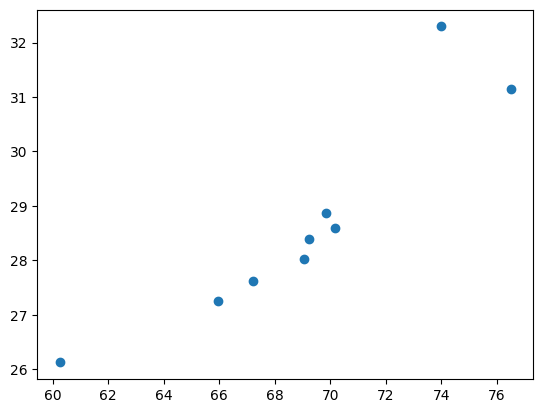

In [17]:
plt.scatter(result_df['rmse'][2::3], result_df['mae'][2::3])

In [48]:
models_name_for_charts = ['LSTM', 'GRU', 'CIFG', 'NFG', 'NIA', 'NIG', 'NOA', 'NOG',
       'Peephole']

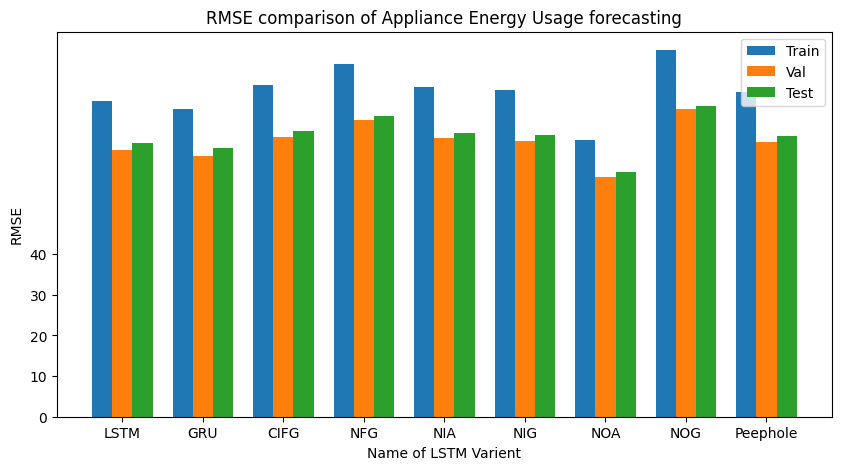

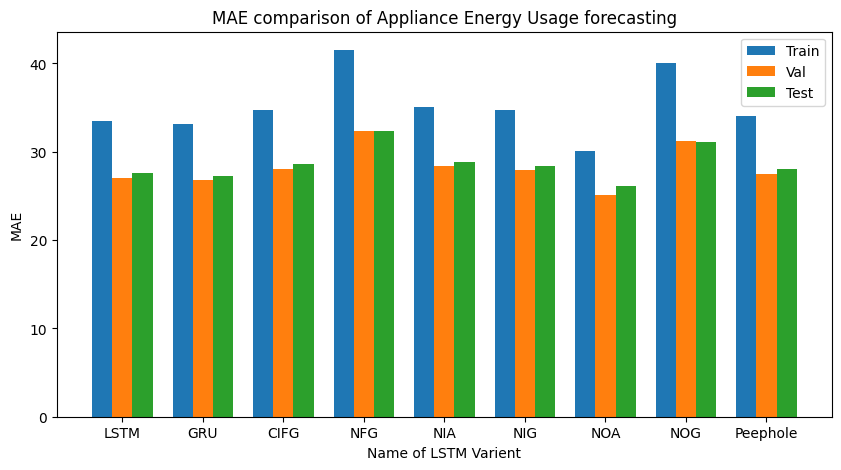

In [78]:
barWidth = 0.25

models_n1 = np.arange(len(models))
models_n2 = [x + barWidth for x in models_n1]
models_n3 = [x + barWidth for x in models_n2]

eval_matrix = {"RMSE":result_df['rmse'], "MAE":result_df['mae']}


for key, m in eval_matrix.items():
  values1 = list(m[0::3].values.reshape(1,-1))
  values2 = list(m[1::3].values.reshape(1,-1))
  values3 = list(m[2::3].values.reshape(1,-1))

  # creating the bar plot
  fig = plt.figure(figsize = (10, 5))
  h1 = plt.bar(models_n1, values1[0], width=0.25, )
  h2 = plt.bar(models_n2, values2[0], width=0.25, )
  h3 = plt.bar(models_n3, values3[0], width=0.25, )
  
  #plt.bar_label(h1,values1)

  plt.xticks([r + barWidth for r in range(len(models))],models_name_for_charts)
  plt.yticks(np.arange(0,50,10),[i for i in np.arange(0,50,10)])
  #plt.yticks([10, 20, 30], ['January', 'February', 'March'],
  #     rotation=45) 
  #plt.bar_label("1")
  plt.legend(dataset_name)
  
  plt.xlabel("Name of LSTM Varient")
  plt.ylabel(key)
  plt.title(key+" comparison of Appliance Energy Usage forecasting")
  plt.savefig(key+'.png', dpi=300)
  plt.show()


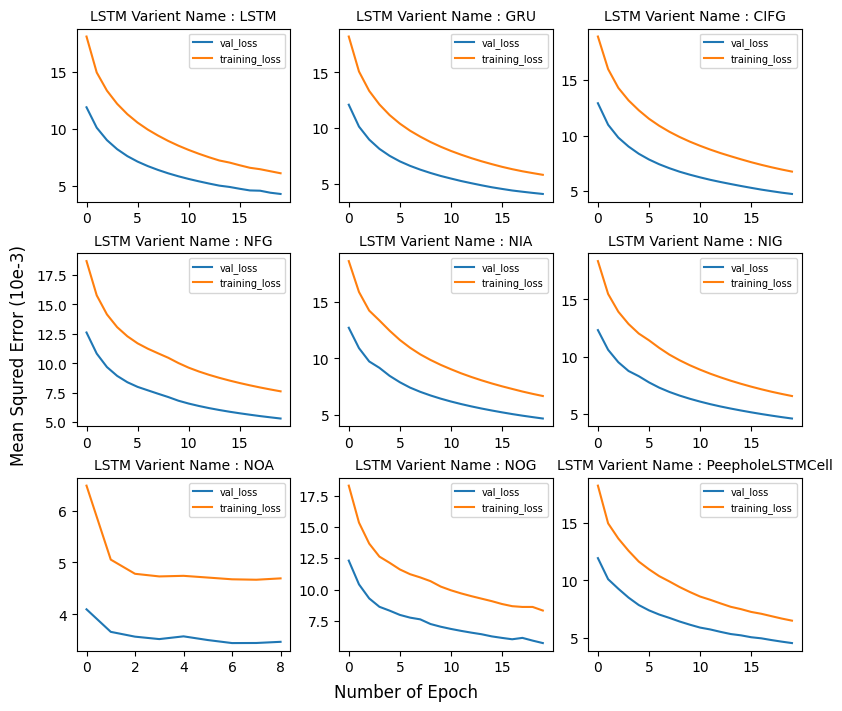

In [134]:
fig, axs = plt.subplots(3, 3, figsize=(8, 7), layout='constrained')
for ax, model_name in zip(axs.flat, history_all):
    ax.set_title(f'LSTM Varient Name : {model_name}', fontsize=10, )
    
    ax.plot(np.array(history_all[model_name].history['val_loss'])/1000)
    ax.plot(np.array(history_all[model_name].history['loss'])/1000)
    
    ax.legend(['val_loss','training_loss'], fontsize = 7)
    fig.supxlabel('Number of Epoch')
    fig.supylabel('Mean Squred Error (10e-3)')
    plt.savefig("all_loss_energy.png", dpi=300)


Text(0, 0.5, 'Loss: Mean Squred Error')

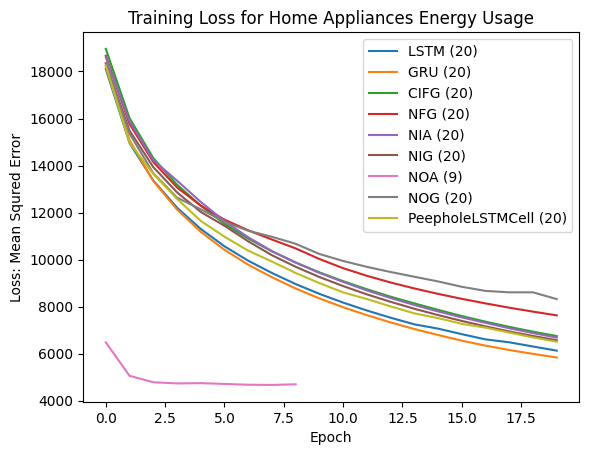

In [132]:
l=[]
for model_name in history_all:
  #print(model_name)
  plt.plot(history_all[model_name].history['loss']) 
  l.append(model_name+" ("+str(len(history_all[model_name].history['loss']))+")")

plt.legend(l)
plt.title("Training Loss for Home Appliances Energy Usage")
plt.xlabel("Epoch")
plt.ylabel("Loss: Mean Squred Error")
#plt.savefig("loss.png", dpi=300)
 